In [1]:
import os
import sys
import inspect
import numpy as np
import pandas as pd
import random
import ast
import string
import time
import itertools
from collections import defaultdict
from itertools import chain, permutations,combinations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
from chord import Chord
import plotly.graph_objects as go
import plotly.offline as py
%matplotlib inline

In [7]:
!pip install chord

Text(0.4, 0.4, '$\\phi_{i}(v) :=  \\sum_{S \\subseteq N\\backslash i}    \\frac{|S|!(n-|S|-1)!}{n!} (v(S\\cup\\{i\\}) - v(S))$')

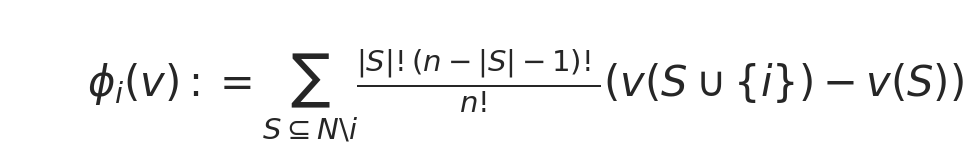

In [2]:
##### Shapely Value Formula #####

a = r'\phi_{i}(v) :=  \sum_{S \subseteq N\backslash i}    \frac{|S|!(n-|S|-1)!}{n!} (v(S\cup\{i\}) - v(S))'
ax = plt.axes([0,0,0.3,0.3]) #left,bottom,width,height
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.text(0.4,0.4,'$%s$' %a,size=30)

In [3]:
n = 100000
df_master = pd.read_csv("paths sample for elite 0305.csv")
df = df_master[:n]
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'paths sample for elite 0305.csv'

In [4]:
"""
def add_start_absorbing_state_func(conversion, path):
    path = ast.literal_eval(path)
    if conversion == 0:
        return ['Start'] + path + ['LOSS']
    else:
        return ['Start'] + path + ['CONVERSION']
"""    

def add_start_absorbing_state_func(conversion, path):
    path = sorted(set(ast.literal_eval(path)))
      
    return tuple(path)    
    
    
df['path'] = df.apply(lambda x: add_start_absorbing_state_func(x['CONVERSION'], x['CAM_DEV']), axis = 1)
df.head(5)    

<ipython-input-4-37a16598df4f>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,PGM_FREQ_MEMBER_KEY,CAM_DEV,CONVERSION,path
0,0,-9223328556171841832,"['NATURAL SEARCH|DESKTOP', 'REFERRAL ENGINE|DE...",1,"(NATURAL SEARCH|DESKTOP, NATURAL SEARCH|MOBILE..."
1,1,-9223242021294710602,"['NATURAL SEARCH|DESKTOP', 'PAID SEARCH|DESKTOP']",1,"(NATURAL SEARCH|DESKTOP, PAID SEARCH|DESKTOP)"
2,2,-9223227354203035958,['DIRECT|DESKTOP'],0,"(DIRECT|DESKTOP,)"
3,3,-9223216806413203389,"['DIRECT|DESKTOP', 'NATURAL SEARCH|DESKTOP']",1,"(DIRECT|DESKTOP, NATURAL SEARCH|DESKTOP)"
4,4,-9223197902225736847,"['NATURAL SEARCH|DESKTOP', 'DIRECT|DESKTOP', '...",1,"(DIRECT|DESKTOP, EMAIL|DESKTOP, NATURAL SEARCH..."


In [5]:
# Perform a groupby and apply a string join.
cols = ['PGM_FREQ_MEMBER_KEY', 'CONVERSION', 'path']
df = df[cols]

df_group = df.groupby(['path','CONVERSION']).agg('count')
df_group = df_group.reset_index()
df_group = df_group.pivot(index='path', columns='CONVERSION', values='PGM_FREQ_MEMBER_KEY').reset_index().fillna(0.0)
df_group["conv_rate"] = df_group[1]/(df_group[0]+df_group[1])
df_group

CONVERSION,path,0,1,conv_rate
0,"(AFFILIATE|DESKTOP,)",270.0,240.0,0.470588
1,"(AFFILIATE|DESKTOP, AFFILIATE|MOBILE)",1.0,3.0,0.750000
2,"(AFFILIATE|DESKTOP, AFFILIATE|MOBILE, DIRECT|D...",0.0,2.0,1.000000
3,"(AFFILIATE|DESKTOP, AFFILIATE|MOBILE, DIRECT|D...",1.0,0.0,0.000000
4,"(AFFILIATE|DESKTOP, AFFILIATE|MOBILE, DIRECT|D...",1.0,0.0,0.000000
...,...,...,...,...
2979,"(SOCIAL MEDIA|MOBILE,)",1.0,2.0,0.666667
2980,"(SOCIAL MEDIA|MOBILE, UNPAID REFERRER|MOBILE)",1.0,0.0,0.000000
2981,"(UNPAID REFERRER|DESKTOP,)",832.0,161.0,0.162135
2982,"(UNPAID REFERRER|DESKTOP, UNPAID REFERRER|MOBILE)",35.0,1.0,0.027778


In [6]:
## df['cookie'].drop_duplicates().shape
## 240,108 cookies 

In [7]:
#### Making a list of unique channels ####
unique_ch = []

for i in df['path']:
    unique_ch +=  list(set(i))
    unique_ch = list(set(unique_ch))
    
# unique_ch[:10], len(unique_ch)    

In [8]:
### return all possible combination of the channel
def power_set(List):
    PS = [list(j) for i in range(len(List)) for j in itertools.combinations(List, i+1)]
    return PS


### return all possible subsets from the channels
def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return list(map(",".join,map(sorted,sub_channels)))

################################################################################

### compute the worth of each coalition
def v_function(A,C_values):
    '''
    This function computes the worth of each coalition.
    inputs:
            - A : a coalition of channels.
            - C_values : A dictionnary containing the number of conversions that 
            each subset of channels has yielded.
    '''
    subsets_of_A = subsets(A)
#     print("########## A #########")
#     print(A)
#     print("Subsets of ",A)
#     print(subsets_of_A)
    worth_of_A=0
    for subset in subsets_of_A:
        if subset in C_values:
            worth_of_A += C_values[subset]
    return worth_of_A



### calculate shapley value
def calculate_shapley(df, channel_name, conv_name):
    '''
    This function returns the shapley values
            - df: A dataframe with the two columns: ['channel_name', 'conv_name'].
            The channel_subset column is the channel(s) associated with the conversion and the 
            count is the sum of the conversions. 
            - channel_name: A string that is the name of the channel column 
            - conv_name: A string that is the name of the column with conversions
            **Make sure that that each value in channel_subset is in alphabetical order. 
            Email,PPC and PPC,Email are the same in regards to this analysis and 
            should be combined under Email,PPC.            
    '''
    # casting the subset into dict, and getting the unique channels
    c_values = df.set_index(channel_name).to_dict()[conv_name]
    df['channels'] = df[channel_name].apply(lambda x: x if len(x.split(",")) == 1 else np.nan)
    channels = list(df['channels'].dropna().unique())
    
    v_values = {}
    for A in power_set(channels): #generate all possible channel combination
        v_values[','.join(sorted(A))] = v_function(A,c_values)
        
    
    n=len(channels) #no. of channels
    shapley_values = defaultdict(int)
    
    print(v_values)
    for channel in channels:
#         print("########Channel########")
#         print(channel)
        for A in v_values.keys():
#             print("######## A ########")
#             print(A)
            if channel not in A.split(","):
                cardinal_A=len(A.split(","))
                A_with_channel = A.split(",")
                A_with_channel.append(channel)            
                A_with_channel=",".join(sorted(A_with_channel))
                weight = (factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n)) # Weight = |S|!(n-|S|-1)!/n!
                contrib = (v_values[A_with_channel]-v_values[A]) # Marginal contribution = v(S U {i})-v(S)
#                 print("########A_with_channel########")
#                 print(A_with_channel)
#                 print("########A_with_channel value########")
#                 print(v_values[A_with_channel])
                shapley_values[channel] += weight * contrib
        # Add the term corresponding to the empty set
        shapley_values[channel]+= v_values[channel]/n 
        
    return shapley_values


def factorial(n):
    
    """ 
    ##Input##
    n : Number
    
    ##Output##
    val: Factorial 
    """
    
    val = n
    
    if n==0:
        return 1
    else:
        val = val*factorial(n-1)
        
    return val

In [9]:
coalition_val = {}
channel_list = unique_ch[:10]

start_time = time.time()
for j in power_set(channel_list):
    tot = 0
    for i in power_set(j):
        if tuple(sorted(i)) in list(df_group['path']):
            tot+= df_group[df_group['path'] == tuple(sorted(i))][1].values[0]      
    coalition_val[tuple(sorted(j))] = tot    
    
end_time = time.time()
delta = end_time-start_time
print("Total time taken is", delta//60, " minutes and ", delta%60, " seconds" )

Total time taken is 0.0  minutes and  28.827937841415405  seconds


In [10]:
shap = {}

for channel in channel_list:
    
    shap[channel] = 0
    for A in coalition_val.keys(): #joblib library for parallel computation, make this for loop as function
        n = len(channel_list)
        
        if channel not in A:
           
            coalition = A
            cardinal_A = len(coalition)
            coalition_with_A = tuple(sorted([channel] + list(coalition)))
           
            margi_contri = coalition_val[coalition_with_A] - coalition_val[coalition]
            
            wt = (factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
            
            shap[channel]+= wt*margi_contri
            
    shap[channel] = coalition_val[tuple([channel])]/n
shap    

{'ECONFO AND PRE-ARRIVAL EMAIL|MOBILE': 0.2,
 'REFERRAL ENGINE|MOBILE': 1.7,
 'NATURAL SEARCH|DESKTOP': 452.8,
 'ECONFO AND PRE-ARRIVAL EMAIL|DESKTOP': 0.7,
 'SOCIAL MEDIA|DESKTOP': 0.1,
 'OTHER|MOBILE': 0.3,
 'REFERRAL ENGINE|DESKTOP': 3.7,
 'DIRECT|DESKTOP': 786.2,
 'EMAIL|DESKTOP': 28.7,
 'DISPLAY|MOBILE': 6.5}

In [11]:

# data = [["E",110],["E,F",11],["E,F,H",8],["E,F,H,I",0], ["E,H",40], ["E,H,I",3], ["E,H,P",1], ["E,I",10], ["E,P",4], ["F",103],
#        ["F,H",72], ["F,H,I",24], ["F,H,P",4], ["F,I",62], ["F,P",22], ["H",280], ["H,I",103], ["H,I,P",12], ["H,P",46], ["I",57],
#        ["I,P",21], ["P",22]]

data = [[tuple("E"),110],[tuple(["E","F"]),11],[tuple(["E","F","H"]),8],[tuple(["E","F","H","I"]),0], [tuple(["E","H"]),40], [tuple(["E","H","I"]),3], 
        [tuple(["E","H","P"]),1], [tuple(["E","I"]),10], [tuple(["E","P"]),4], [tuple("F"),103],[tuple(["F","H"]),72], 
        [tuple(["F","H","I"]),24], [tuple(["F","H","P"]),4], [tuple(["F","I"]),62], [tuple(["F","P"]),22], [tuple("H"),280], 
        [tuple(["H","I"]),103], [tuple(["H","I","P"]),12], [tuple(["H","P"]),46], [tuple("I"),57],[tuple(["I","P"]),21],
        [tuple(["P"]),22]]

df_group = pd.DataFrame(data, columns = ['path', 1])
# df_group_rn['path'] = df_group_rn.apply(lambda x: tuple(x['path_old']), axis = 1)



coalition_val = {}
channel_list = ['E', 'F', 'H', 'I', 'P']

start_time = time.time()
for j in power_set(channel_list):
    tot = 0
    for i in power_set(j):
        
        if tuple(sorted(i)) in list(df_group['path']):
            
            tot+= df_group[df_group['path'] == tuple(sorted(i))][1].values[0]      
    coalition_val[tuple(sorted(j))] = tot    
    
end_time = time.time()
delta = end_time-start_time
print("Total time taken is", delta//60, " minutes and ", delta%60, " seconds" )



shap = {}

for channel in channel_list:
    
    shap[channel] = 0
    for A in coalition_val.keys():
        n = len(channel_list)
        
        if channel not in A:
           
            coalition = A
            cardinal_A = len(coalition)
            coalition_with_A = tuple(sorted([channel] + list(coalition)))
           
            margi_contri = coalition_val[coalition_with_A] - coalition_val[coalition]
            
            wt = (factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
            
            shap[channel]+= wt*margi_contri
            
    shap[channel] += coalition_val[tuple([channel])]/n
    
    
shap, df_group[1].sum(), sum(list(shap.values()))    


Total time taken is 0.0  minutes and  0.0687861442565918  seconds


({'E': 146.5,
  'F': 198.50000000000003,
  'H': 427.83333333333337,
  'I': 168.00000000000003,
  'P': 74.16666666666667},
 1015,
 1015.0)

# Recursive Defination 

In [12]:
def shap_calc(coal_tuple, ch):
    
    if len(coal_tuple) == 1:
        return coalition_val[coal_tuple]
    
    else:
        
        copy_coal_tuple = coal_tuple
        
        val1 = coalition_val[copy_coal_tuple]
        
        copy_coal_list = list(coal_tuple)
        copy_coal_list.remove(ch)
        copy_coal_tuple_slice = tuple(copy_coal_list)
        
        val2 = coalition_val[copy_coal_tuple_slice]
        
        tot = val1 - val2
        
        for i in copy_coal_list:
            
            coalition_list_copy = list(coal_tuple)
            coalition_list_copy.remove(i)
            coalition_tuple_copy = tuple(coalition_list_copy)
            
            tot += shap_calc(coalition_tuple_copy, ch)
        
        return tot/len(coal_tuple)

In [13]:

# data = [["E",110],["E,F",11],["E,F,H",8],["E,F,H,I",0], ["E,H",40], ["E,H,I",3], ["E,H,P",1], ["E,I",10], ["E,P",4], ["F",103],
#        ["F,H",72], ["F,H,I",24], ["F,H,P",4], ["F,I",62], ["F,P",22], ["H",280], ["H,I",103], ["H,I,P",12], ["H,P",46], ["I",57],
#        ["I,P",21], ["P",22]]

data = [[tuple("E"),110],[tuple(["E","F"]),11],[tuple(["E","F","H"]),8],[tuple(["E","F","H","I"]),0], [tuple(["E","H"]),40], [tuple(["E","H","I"]),3], 
        [tuple(["E","H","P"]),1], [tuple(["E","I"]),10], [tuple(["E","P"]),4], [tuple("F"),103],[tuple(["F","H"]),72], 
        [tuple(["F","H","I"]),24], [tuple(["F","H","P"]),4], [tuple(["F","I"]),62], [tuple(["F","P"]),22], [tuple("H"),280], 
        [tuple(["H","I"]),103], [tuple(["H","I","P"]),12], [tuple(["H","P"]),46], [tuple("I"),57],[tuple(["I","P"]),21],
        [tuple(["P"]),22]]

df_group = pd.DataFrame(data, columns = ['path', 1])
# df_group_rn['path'] = df_group_rn.apply(lambda x: tuple(x['path_old']), axis = 1)



coalition_val = {}
channel_list = ['E', 'F', 'H', 'I', 'P']

start_time = time.time()
for j in power_set(channel_list):
    tot = 0
    for i in power_set(j):
        
        if tuple(sorted(i)) in list(df_group['path']):
            
            tot+= df_group[df_group['path'] == tuple(sorted(i))][1].values[0]      
    coalition_val[tuple(sorted(j))] = tot    
    


shap = {}

grand_coalition = tuple(list(coalition_val.keys())[-1])

for ch in channel_list:
    
    shap[ch] = shap_calc(grand_coalition, ch)   
    
    
shap      

{'E': 146.5,
 'F': 198.5,
 'H': 427.8333333333333,
 'I': 168.0,
 'P': 74.16666666666666}